In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../../data/raw/reviews.csv')
df.head()

,Sentiment,Time,Text
0,positive,18/6/21,This is a very healthy dog food. Good for thei...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...
2,positive,18/6/21,"Before I was educated about feline nutrition, ..."
3,positive,7/7/21,"My holistic vet recommended this, along with a..."
4,positive,1/7/21,I bought this coffee because its much cheaper ...


In [3]:
X,y = df['Text'].values,df['Sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (4083,)
shape of test data is (1361,)


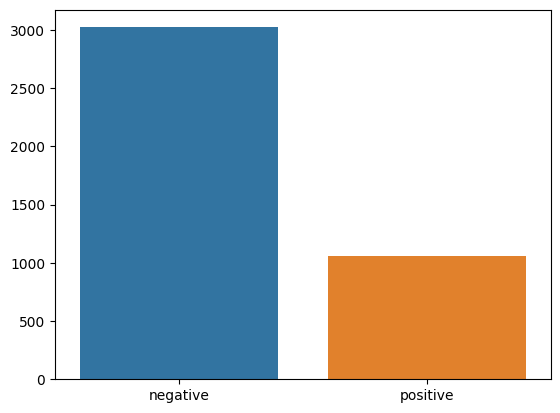

In [4]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def create_word_list(x_train):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split(' '):
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    return word_list
word_list = create_word_list(x_train)

In [6]:
def tokenize(x_train, y_train, x_test, y_test):
    corpus = Counter(word_list)
    corpus_ = sorted(corpus.items(), key = lambda x: x[1], reverse=True)[:1000]
    onehot_dict = {w[0]:i+1 for i, w in enumerate(corpus_)}

    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_test] 
    return np.array(final_list_train, dtype = 'object'), np.array(encoded_train),np.array(final_list_test, dtype = 'object'), np.array(encoded_test),onehot_dict

In [7]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

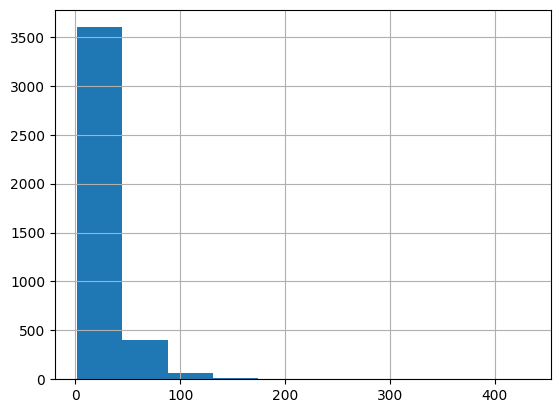

count    4083.000000
mean       24.686505
std        22.162957
min         2.000000
25%        12.000000
50%        18.000000
75%        30.000000
max       432.000000
dtype: float64

In [8]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [9]:
def padding(sents, seq_len):
    features = np.zeros((len(sents), seq_len), dtype = int)
    for i, rev in enumerate(sents):
        if len(rev) != 0:
            features[i, -len(rev):] = np.array(rev)[:seq_len]
    return features

In [10]:
# we have very less number of reviews of length > 500, so we will take review uptill length 500 only
x_train_pad = padding(x_train, 500)
x_test_pad = padding(x_test, 500)

In [11]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# batch size
batch_size = 10

# shuffle data

train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle= True, batch_size = batch_size, drop_last = True)

In [12]:
for i, batch in enumerate(train_loader):
#     print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[0])
    print(batch[1])

    break

torch.Size([10, 500])
torch.Size([10])
tensor([[  0,   0,   0,  ...,  64, 164,  36],
        [  0,   0,   0,  ..., 433,   2,   8],
        [  0,   0,   0,  ...,   1, 203, 921],
        ...,
        [  0,   0,   0,  ..., 128, 229,  10],
        [  0,   0,   0,  ..., 176,  94,  36],
        [  0,   0,   0,  ...,  96, 330, 219]])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1])


In [13]:
#obtain one batch
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print(f"Size of Batch {sample_x.size()}")
print(f"Sample input {sample_x}")
print(f"Sample output {sample_y}")
# obtain one batch of training data

Size of Batch torch.Size([10, 500])
Sample input tensor([[  0,   0,   0,  ..., 191, 450, 900],
        [  0,   0,   0,  ..., 216, 416,  22],
        [  0,   0,   0,  ..., 157, 194, 157],
        ...,
        [  0,   0,   0,  ..., 592, 197, 105],
        [  0,   0,   0,  ...,  50, 200, 254],
        [  0,   0,   0,  ...,  89,  12, 565]])
Sample output tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1])


In [14]:
class SentimentLSTM(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5):
        super(SentimentLSTM, self).__init__()
        
        self.no_layers = no_layers
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        
        #LSTM
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = self.hidden_dim, num_layers = no_layers, batch_first=True)
        
        #dropout layers
        self.dropout = nn.Dropout(0.3)
        
        #linear and Sigmoid layer
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # we just passed a batch
        batch_size = x.size(0) # batch size -> B
        #embed shape -> [B, max_len, embed_dim]
        embeds = self.embedding(x)
        
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        
        # drop out and fully connected
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid 
        
        sig_out = self.sig(out)
        #reshape to batch size first
        
        sig_out = sig_out.view(batch_size, -1)
        
        sig_out = sig_out[:, -1]
        
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        
        # create hidden state and cell state tensors with size [no_layers x batch_size x hidden_dim]
        
        hidden_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim))
        cell_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim))
        hidden = (hidden_state, cell_state)
        return hidden

In [15]:
no_layers = 2 # no of layers in lstm
vocab_size = len(vocab) + 1 # extra for 0 (padding symbol)
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentLSTM(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5)

model

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [16]:
# loss and optimization features

lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# accuracy function
def accuracy(pred, label):
    pred =torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [18]:
clip = 5
epochs = 5
test_loss_min = np.Inf
epoch_tr_loss, epoch_tst_loss = [], []
epoch_tr_acc, epoch_tst_acc = [], []

for epoch in range(epochs):
    train_loss = []
    train_acc = 0
    h = model.init_hidden(batch_size)
    model.train()
    # processing each batch
    for x, y in train_loader:
        x, y = x, y
        
        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(x, h)
        
        #calculate loss
        
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        train_loss.append(loss.item())
        
        #acuracy
        
        acc = accuracy(output, y)
        
        train_acc += acc
        #clip_Grad_norm clips the grad or simply prevents exploding of gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    test_h = model.init_hidden(batch_size)
    test_loss = []
    test_acc = 0
    model.eval()
    for x, y in test_loader:
        x, y = x, y
        test_h = tuple([each.data for each in test_h])
        
        output, test_h = model(x, test_h)
        
        loss = criterion(output.squeeze(), y.float())
        test_loss.append(loss.item())
        
        acc = accuracy(output, y)
        
        test_acc += acc
        
    epoch_train_loss = np.mean(train_loss) # take average loss for each batch
    epoch_test_loss = np.mean(test_loss)
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tst_loss.append(epoch_test_loss)
    
    epoch_train_acc = train_acc / len(train_loader.dataset)
    
    epoch_test_acc = test_acc / len(test_loader.dataset)
    
    epoch_tr_acc.append(epoch_train_acc)
    epoch_tst_acc.append(epoch_test_acc)
    
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} test_loss : {epoch_test_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} test_accuracy : {epoch_test_acc*100}')
    if epoch_test_loss <= test_loss_min:
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,epoch_test_loss))
        test_loss_min = epoch_test_loss
    print(25*'==')

Epoch 1
train_loss : 0.38221081510624466 test_loss : 0.41141192560248513
train_accuracy : 83.6884643644379 test_accuracy : 80.67597354886114
Validation loss decreased (inf --> 0.411412).  Saving model ...
Epoch 2
train_loss : 0.30474677988711524 test_loss : 0.4152602575281087
train_accuracy : 87.36223365172667 test_accuracy : 79.50036737692872
Epoch 3
train_loss : 0.2210737874813597 test_loss : 0.4654055605916416
train_accuracy : 91.55033063923585 test_accuracy : 82.14548126377663
Epoch 4
train_loss : 0.15104348810763993 test_loss : 0.515642842003966
train_accuracy : 94.58731325006123 test_accuracy : 82.51285819250552
Epoch 5
train_loss : 0.08491000647350744 test_loss : 0.7102895415155217
train_accuracy : 97.25691893215773 test_accuracy : 81.41072740631888


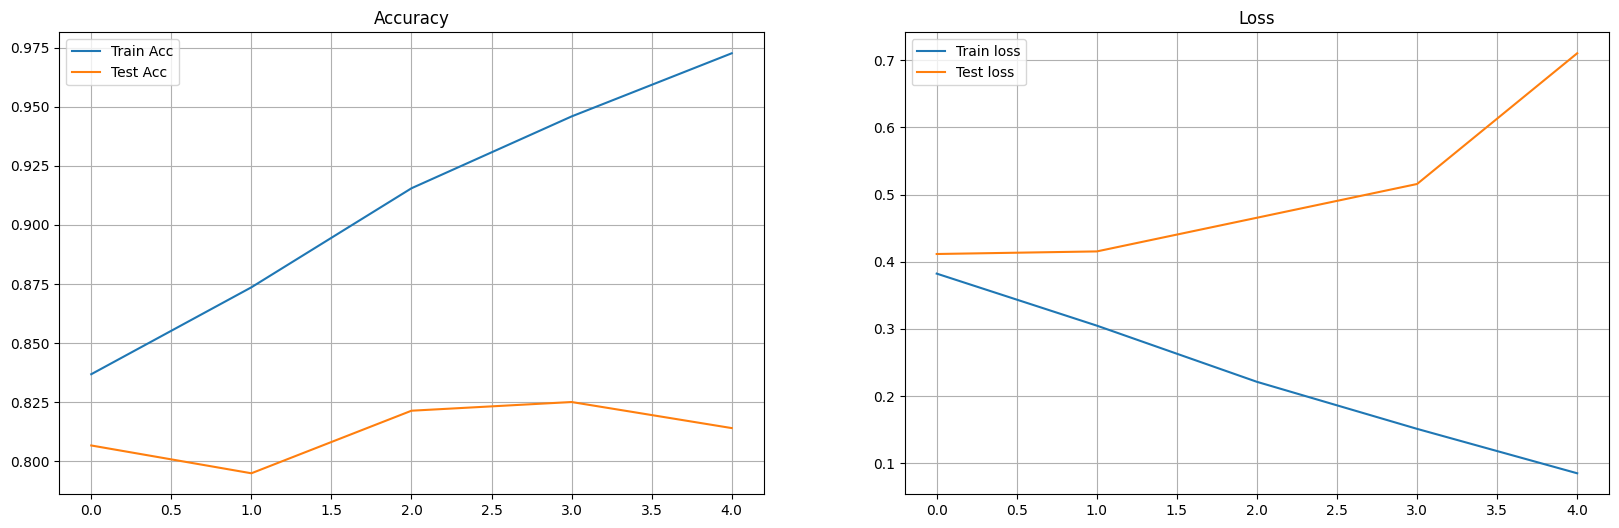

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_tst_acc, label='Test Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_tst_loss, label='Test loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [30]:
def predict_sentiment(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis = 0)
    print(word_seq)
    pad = torch.from_numpy(padding(word_seq, 500))
    
    inputs = pad
    batch_size = 1
    h = model.init_hidden(batch_size)
    output, h = model(inputs, h)
    return output.item()

In [35]:
df[df['Sentiment'] == 'negative']

,Sentiment,Time,Text
44,negative,10/3/21,SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEA...
62,negative,25/4/21,I ordered a flat of food (they were on sale) t...
70,negative,28/9/21,"Unlike another product I reviewed for Vine, at..."
76,negative,25/5/21,Gimme better ingredients (KIND/Larabars) for m...
93,negative,3/6/21,do not fed your dog any happy hip = dogswell p...
...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med..."
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...
5442,negative,13/9/20,This product was very good when I began buying...


In [38]:
index = 44
review, sentiment = df['Text'][index], df['Sentiment'][index]
print("The statement is:")
print(review)
print("=="*25)
print(f"Original Sentiment is: {sentiment}")
print("=="*25)
pred = predict_sentiment(review)
status = "positive" if pred > 0.5 else "negative"
print(f"Predicted Sentiment is {status} with probability of {pred}.")

The statement is:
SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEASE GIVE REAL FOOD TO HUNGRY PEOPLE,<br /><br />What's in Kellogg's Corn Flakes? "Milled Corn, Sugar, Malt Flavoring, High Fructose Corn Syrup, Salt." Yes, of course, it also has lots of yummy preservatives such as BHT and a few synthetic vitamins and iron in minute quantities. For nutrition you get basically 100% Carbs from lots of SUGAR and almost NO PROTEIN. Add skim milk, or you'll get saturated fat with a little protein from whole milk. For added nutrition, include a sliced banana and a capful of wheat germ.<br /><br />If you like Corn Flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than 0.29 cents an ounce [$3.49 per package]. At this price, the inner package's failure to maintain freshness is an even bigger drawback when one thinks of how long it may take to finish 12 ounces of this stuff. Why not use a vacuum-sealed container like Kretschmer's

In [39]:
index = 70
review, sentiment = df['Text'][index], df['Sentiment'][index]
print("The statement is:")
print(review)
print("=="*25)
print(f"Original Sentiment is: {sentiment}")
print("=="*25)
pred = predict_sentiment(review)
status = "positive" if pred > 0.5 else "negative"
print(f"Predicted Sentiment is {status} with probability of {pred}.")

The statement is:
Unlike another product I reviewed for Vine, at least this product does not have sugar per se in it. It is carbonated water added to a concentrate mixture of (in this order): apple, grape, tangerine and last - as well as least -- acai concentrate. The first two on the list, apple and grape are two of the most common "fruit" sweeteners used in beverages etc. That is why the product tastes sweetened.<br /><br />It has 140 calories -- quite a lot for 8 oz of flavored carbonated water -- and all of it is from carbohydrates (36 grams) and over 90% of the carbs (34 grams) are sugars. Apple and grapes have some of the highest concentrations of "fructose" a fruit sugar that not only commonly appears in commercial beverages because it is sweeter than regular cane sugar and thus it is cheaper to use, but it is also known to cause diarrhea, particularly in children.<br /><br />So another drink on the hit parade of "pretend" healthy drinks- appealing to the masses' concern for the

In [40]:
index = 62
review, sentiment = df['Text'][index], df['Sentiment'][index]
print("The statement is:")
print(review)
print("=="*25)
print(f"Original Sentiment is: {sentiment}")
print("=="*25)
pred = predict_sentiment(review)
status = "positive" if pred > 0.5 else "negative"
print(f"Predicted Sentiment is {status} with probability of {pred}.")

The statement is:
I ordered a flat of food (they were on sale) that contained Chicken Apple Compote Dinner. It contained 3 of this variety and he liked the first one but the others, although properly sealed, were solid and moldy and stinky.<br />One of the Turkey dinners in the flat was also improperly sealed; the lid popped. We were lucky because I just happened to check that one. Now I'm so paranoid that I check all of them several times. I called Earth's Best and they assured me that they haven't had this problem before and that I shouldn't worry about it. I'm so suprised that this got passed QA/QC inspection at a baby food manufacturer. Why would a company take the risk of bad publicity when baby food manufacturers rely so much on a reputation of safety?!<br /><br />We also recently opened 5 other jars in this flat after my son refused to eat them and realized that they were rotten.  3 of them were completely solid and domed at the top!  We poked a toothpick down to the bottom of t

Test on user generated data

In [44]:
review = "The product does seem to be different from what is show on the webite, it is also slightly expensive, would not buy again"
pred = predict_sentiment(review)
status = "positive" if pred > 0.5 else "negative"
print(f"Predicted Sentiment is {status} with probability of {pred}.")

[[  6 349 100  23 391 140  10  20]]
Predicted Sentiment is negative with probability of 0.1204124316573143.


26% of data has negative sentiments
74% of data has positive sentiments

Data is slightly unbalanced and as seen from the model, the predicted probability for negative sentiment seems to be quite low. The model is good at classifying positive reviews but can be better on negative ones.

Things to do next:
    - hyperparameter tuning 
    - can tune threshold in which we determine whether sentiment is +/-, currently it is at 0.5
    - try other models such as XGboost which is great for unbalanced dataset
    


In [ ]:
X = df['clean_reviews']
y = df['Sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8") #822MB, not uploaded onto git

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### LSTM (RNN)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()